# Thinking about movies and words in high-dimensional space

As chapter 6 of Jurafsky and Martin explained, both the columns and the rows of a term-document matrix can be understood geometrically as points in space. (Or, if you prefer, as *vectors* drawn from the origin of a coordinate system to a particular point.)

![A term-doc matrix and vector representation of same](jurafskyvector.png)

To make visualization easier, the textbook has chosen two dimensions here. But the space defined by the term-document matrix really has four dimensions. We can't easily draw a picture of four-dimensional space, but it's perfectly possible to measure distance there.

See section 6.4 of Jurafsky and Martin for a mathematical explanation of "cosine similarity." The cosine ranges from -1 to 1, and is largest when two vectors are very *similar.* (As you can see below, the cosine gets smaller as the angle X gets larger.)

![https://www.quora.com/Mathematics-Why-does-the-obtuse-angle-of-cos-x-give-a-negative-value](cosine.png)

To convert it into something more like a distance, it's conventional to measure

1 - cos(X)

which can be called "cosine distance."

In this notebook, we'll explore ways to reason geometrically about cultural objects by treating them as points in high-dimensional space. The examples we'll use are movies and movie characters, but much of this logic will apply also to images.

We will

1. Compare features (words) and instances (movies) by measuring the cosine distance between them,

2. Cluster movie scripts in semantic space, and

3. Flatten high-dimensional space into a plane, using a variety of *dimension reduction* techniques. Some information will be lost when we do this, but it's still a useful way to explore complex data.

### Import useful modules and read data

We'll be using the same dialogue data we used last time.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import seaborn as sns
import math, re
from scipy.spatial.distance import cosine
from collections import Counter

We start by reading in the old dataframe, with one row per character.

In [2]:
dialogpath = Path('../../data/movie_dialogue.tsv')

chars = pd.read_csv(dialogpath, sep = '\t')

chars.head()

,mid,cid,cname,mname,gender,wordcount,year,genres,comedy,thriller,drama,romance,lines
0,m0,u0,BIANCA,10 things i hate about you,f,959,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...
1,m0,u2,CAMERON,10 things i hate about you,m,527,1999,"['comedy', 'romance']",True,False,False,True,"They do to! / She okay? / Wow / No / The ""real..."
2,m0,u4,JOEY,10 things i hate about you,m,278,1999,"['comedy', 'romance']",True,False,False,True,"Listen, I want to talk to you about the prom. ..."
3,m0,u5,KAT,10 things i hate about you,f,1217,1999,"['comedy', 'romance']",True,False,False,True,Perm? / It's just you. / What? To completely d...
4,m0,u6,MANDELLA,10 things i hate about you,f,157,1999,"['comedy', 'romance']",True,False,False,True,William - he asked me to meet him here. / Have...


### Aggregate dialogue at the movie level

But for this problem, it's more manageable (at least initially) to talk about movies rather than characters. So let's aggregate the dialogue at the movie level.

```.groupby()``` helps with this, but it's still not a totally straightforward task. It's hard to avoid writing a loop.

In [3]:
# A simple-to-understand, if clunky, way to group by movie
# We start by creating a dictionary with column labels as 
# the keys; each value will be a list that turns into a
# column in a new dataframe with one row per movie.

movie_dict = dict()
exclude = {'cid', 'cname', 'gender'}  # movies don't have these

for col in chars.columns:
    if not col in exclude:
        movie_dict[col] = []    # initialize the list
        
movie_dict['action'] = []   # we're also going to add a column for action films

for movie_id, df in chars.groupby('mid'):
    
    dialogue = ' '.join([x for x in df['lines']])  #
    movie_dict['lines'].append(dialogue)
    
    for col in chars.columns:
        if col in exclude or col == 'lines' or col == 'wordcount':
            continue
        else:
            movie_dict[col].append(df[col].values[0]) # for most columns all rows
                                                # of the grouped df are the same
                                                # so just take the first entry
    
    movie_dict['wordcount'].append(np.sum(df['wordcount']))  # sum
    
    if 'action' in df['genres'].values[0]:
        actionval = True
    else:
        actionval = False
    movie_dict['action'].append(actionval)
    
movies = pd.DataFrame(movie_dict)
movies = movies.set_index('mname')
movies.head()

,mid,wordcount,year,genres,comedy,thriller,drama,romance,lines,action
mname,,,,,,,,,,
10 things i hate about you,m0,5159,1999,"['comedy', 'romance']",True,False,False,True,They do not! / I hope so. / Let's go. / Okay -...,False
1492: conquest of paradise,m1,1474,1992,"['adventure', 'biography', 'drama', 'history']",False,False,True,False,Asia can be found to the west -- and I will pr...,False
affliction,m10,5896,1997,"['drama', 'mystery', 'thriller']",False,True,True,False,All the figures show is that Gordon LaRiviere ...,False
innerspace,m100,5181,1987,"['action', 'adventure', 'comedy', 'crime', 'sc...",True,False,False,False,Sending what we know back to U.S.T. via satell...,True
the insider,m101,6418,1999,"['biography', 'drama', 'thriller']",False,True,True,False,The New York Times ran a blow by blow of what ...,False


#### Build vocabulary

In the past we've let the CountVectorizer define its own vocabulary. But it's actually a little naive to create a vocabulary by just counting the number of words in a corpus. It's often better to select words by *document frequency*. If "Leia," for instance, appears 105 times in 3 movies, the document frequency of Leia is 3--which might be a better reflection of its importance in the corpus than 105.

In [64]:
vocab = Counter()

for script in movies['lines']:
    words = re.split('\W', script)
    one_each = set([w for w in words if len(w) > 1])  # get rid of one-letter words, often noise
    for w in one_each:
        if not w.isdigit() and not w[0].isupper():    # get rid of numbers and names
            vocab[w.lower()] += 1
        
vocab = vocab.most_common(5000)   # This is a Counter() method that returns paired
                                  # keys and counts for the keys with highest counts.

Let's see what's actually in ```vocab.```

In [65]:
print("Most common words:", vocab[0:10], '\n')
print("Least common words (in top 5000)", vocab[-10: ])

Most common words: [('the', 601), ('what', 600), ('to', 600), ('it', 600), ('you', 600), ('of', 599), ('know', 599), ('me', 599), ('are', 599), ('that', 599)] 

Least common words (in top 5000) [('referred', 12), ('deposition', 12), ('document', 12), ('threats', 12), ('ratings', 12), ('inject', 12), ('fragile', 12), ('worthwhile', 12), ('yacht', 12), ('heavens', 12)]


We want to split apart the words (we'll call them ```lexicon```) and the document frequencies.

In [66]:
lexicon = [x[0] for x in vocab]     # this syntax is called a 'list comprehension'
docfreqs = [x[1] for x in vocab]

Now count all the words in lexicon. Notice that the words are now in frequency order rather than alphabetical order. There will also be fewer numbers and names.

In [67]:
vectorizer = CountVectorizer(vocabulary = lexicon)
all_movie_ids = movies.index.tolist()
sparse_counts = vectorizer.fit_transform(movies['lines']) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
moviecounts = pd.DataFrame(sparse_counts.toarray(), index = all_movie_ids, 
                            columns = vectorizer.get_feature_names())
moviecounts.head()

,the,what,to,it,you,of,know,me,are,that,...,referred,deposition,document,threats,ratings,inject,fragile,worthwhile,yacht,heavens
10 things i hate about you,133,65,143,81,289,53,42,71,19,84,...,0,0,0,0,0,0,0,0,0,0
1492: conquest of paradise,51,20,55,12,71,26,8,15,20,13,...,0,0,0,0,0,0,0,0,0,0
affliction,170,67,142,149,285,62,56,65,27,91,...,0,0,0,0,0,0,0,0,0,0
innerspace,112,161,122,143,340,59,55,54,52,71,...,0,0,0,0,0,0,0,0,0,0
the insider,219,112,194,127,298,87,45,51,58,108,...,2,3,2,1,1,0,0,0,0,0


A final refinement. If we're looking for similarities and differences between films, a word like 'gambler' is more valuable than would be suggested by its rarity, and a word like 'the' is a little less useful than its frequency would suggest. So we can adjust the term frequencies (columns) by dividing them by the document frequencies of those terms. This technique--which slightly increases the weight assigned to rare words--is called tf-idf (term-frequency-inverse-document-frequency).

In [68]:
moviefreqs = moviecounts.divide(docfreqs, axis = 'columns') 
moviefreqs.head()

,the,what,to,it,you,of,know,me,are,that,...,referred,deposition,document,threats,ratings,inject,fragile,worthwhile,yacht,heavens
10 things i hate about you,0.221298,0.108333,0.238333,0.135000,0.481667,0.088481,0.070117,0.118531,0.031720,0.140234,...,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1492: conquest of paradise,0.084859,0.033333,0.091667,0.020000,0.118333,0.043406,0.013356,0.025042,0.033389,0.021703,...,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
affliction,0.282862,0.111667,0.236667,0.248333,0.475000,0.103506,0.093489,0.108514,0.045075,0.151920,...,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
innerspace,0.186356,0.268333,0.203333,0.238333,0.566667,0.098497,0.091820,0.090150,0.086811,0.118531,...,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
the insider,0.364393,0.186667,0.323333,0.211667,0.496667,0.145242,0.075125,0.085142,0.096828,0.180301,...,0.166667,0.25,0.166667,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0


Note that we haven't yet done what we did in an earlier lab notebook: normalized the rows to adjust for the fact that some movies just have more words than others (or more talkative characters in our dataset). A week ago we made that adjustment by dividing each row by its sum.

But it's not absolutely necessary to do that as long as we're using cosine distance to compare the movies. Cosine distance measures the angle between vectors, not the length of the vectors. See [the figure I borrowed from Quora](https://www.quora.com/Mathematics-Why-does-the-obtuse-angle-of-cos-x-give-a-negative-value) below: the Eucidean distance between D and E is greater than the distance between A and B, because the vectors to D and E are longer. But the angle, and cosine distance, between both pairs of points is the same.

![A figure from Quora](cosversuseuclid.png)

So, as long as we're measuring by cosine, it doesn't matter if the numbers in some rows are bigger than in other rows--what matters for the angle are the relative *proportions* between columns. (Remember that each column represents a dimension in 5000-dimensional space.)

Leaving movie "lengths" uneven does mean that longer scripts will have more weight in comparisons between words. But that's arguably a good side-effect.

### Using cosine distance to group words and movies

When we used a term-document matrix for predictive modeling, we needed to have a known set of labels--indicating the genre of a movie or the gender of a character. That's *supervised* modeling. But we can also use this data in an *unsupervised* fashion to detect patterns. There will be many kinds of unsupervised (or self-supervised) modeling, but a first step in that direction is to measure distances between rows or between columns. 

The code below allows you to enter a column (a word), and then finds other words that are closest to it in "movie-space" -- that is, in terms of their distribution across movies. Is closeness-in-movie-space the same thing as a word's "meaning"? Experiment, see what you think, and discuss in breakout groups. I recommend trying "monster" and "gamble" as well as a few common words.

In [70]:
wordtomatch = input('word to match? ')

if wordtomatch not in moviefreqs.columns:
    print("I'm sorry, that's not a word in the columns of the matrix.")
else:
    matches = []

    for w in moviefreqs.columns:
        if w == wordtomatch:
            continue
        else:
            cosdist = cosine(moviefreqs[w], moviefreqs[wordtomatch])
            matches.append((cosdist, w))

    matches.sort()
    for distance, title in matches[0:5]:
        print(distance, title)
        

word to match?  star


0.5139621885808139 movie
0.5170798525446222 script
0.5564264127746268 picture
0.5775491965836863 horror
0.5961124438314385 comic


We can use the same technique to compare rows (movie scripts) in word-space. Do these results conform to our intuitions about the similarity of movies? Experiment and discuss. I suggest trying "the godfather," "jaws," "shakespeare in love," and "vertigo." What aspects of artistic similarity get ignored, or exaggerated, if we use this measure?

In [72]:
movietomatch = input('movie to match? ')

if movietomatch not in moviefreqs.index:
    print("I'm sorry, that's not a title in the index of the matrix.")
else:
    matches = []

    for m in moviefreqs.index:
        if m == movietomatch:
            continue
        else:
            cosdist = cosine(moviefreqs.loc[m], moviefreqs.loc[movietomatch])
            matches.append((cosdist, m))

    matches.sort()
    for distance, title in matches[0:5]:
        print(distance, title)

movie to match?  dead poets society


0.49616381416732347 good will hunting
0.4970192737969854 the graduate
0.513159666473465 peggy sue got married
0.5168230414627626 shampoo
0.517432088401328 nurse betty


**PAUSE HERE FOR BREAKOUT GROUP DISCUSSION**

### Hierarchical clustering

Comparing individual pairs of movies is fun. But we don't have to think about similarity in this one-by-one way. Now that we can measure distances between scripts, we can use a *clustering algorithm* to look for groups of similar scripts. (You may recognize this technique from Allison et al. We're going to skip some of the details of feature engineering and feature selection that the Stanford group dwell on; in 2011 it seemed possible that you would only get good results if you selected features using a special method, but in 2021 we've come to recognize that selecting *n* common words by document frequency usually works just fine.)

To illustrate this method at its best, let's select a group of movies that has a few pairs that clearly belong together.

In [87]:
selected = ['the godfather', 'dead poets society',
            'good will hunting', 'jaws', 'the graduate', 
            'jaws 2', 'the godfather: part ii',
           'star wars', 'star trek: the wrath of khan']
small_movie_df = movies.loc[movies.index.isin(selected), : ]
small_movie_df

,mid,wordcount,year,genres,comedy,thriller,drama,romance,lines,action
mname,,,,,,,,,,
jaws,m108,4204,1975,['thriller'],False,True,False,False,Here -- Take him home. / Just a favor for you...,False
star trek: the wrath of khan,m193,4091,1982,"['action', 'adventure', 'sci-fi', 'thriller']",False,True,False,False,You're not going in there -- ! / Are you out o...,True
the godfather,m203,4861,1972,"['crime', 'drama', 'thriller']",False,True,True,False,"I want you to use all your powers, all your sk...",False
dead poets society,m318,4099,1989,['drama'],False,False,True,False,"Cameron, what is the matter with you. You act ...",False
the godfather: part ii,m369,7225,1974,"['crime', 'drama', 'thriller']",False,True,True,False,"Mike, what can I do, she's a hysterical woman....",False
good will hunting,m373,9341,1997,['drama'],False,False,True,False,"No, he was so hammered that he drove the polic...",False
jaws 2,m403,3164,1978,['thriller'],False,True,False,False,I need a hand here.... / What is it? What's t...,False
star wars,m529,3209,1977,"['action', 'adventure', 'fantasy', 'sci-fi']",False,False,False,False,May the Force be with you. / That's straight t...,True
the graduate,m77,7147,1967,"['comedy', 'drama', 'romance']",True,False,True,True,What? / The day after tomorrow? / Are we getti...,False


Now we create a dataframe of word frequencies just for these movies, and normalize it so each row has the same Euclidean "length." Read the comments in the code below to understand why we have to do that. If you're curious how I knew I would have to do that, you can check out [the documentation of the ```AgglomerativeClustering``` class we're about to use.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [88]:
small_moviefreqs = moviefreqs.loc[selected, :]     # get the word frequencies for our movies

# The hierarchical clustering algorithm uses Euclidean distance by default.
# But when you're using Euclidean distance, the lengths of vectors matter!

# We could ignore the fact that some movies have more words than others
# as long as we were using cosine distances, but if we're going to use
# Euclidean, we need to normalize to make the lengths of all the rows
# equal. np.linalg.norm measures the "length" of a vector (l2 norm).

vectorlengths = np.linalg.norm(small_moviefreqs, ord = 2, axis = 1)
print("Original vector lengths: ", vectorlengths[0:10])

small_moviefreqs = small_moviefreqs.divide(vectorlengths, axis = 'rows')

vectorlengths = np.linalg.norm(small_moviefreqs, ord = 2, axis = 1)
print("After normalizing: ", vectorlengths[0:10])

Original vector lengths:  [1.22463737 1.02419979 1.89060045 1.19587154 1.40758193 0.91056011
 1.83817893 1.16298052 1.23871888]
After normalizing:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]


Now we import some functions for hierarchical clustering, and actually build the clustering model.

In [89]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters = None)
clustering = model.fit(small_moviefreqs)

Clustering proper was easy.

The long code snippet below is mostly about creating a pretty dataviz; don't worry about the details for now. There will be time to figure out the details if you actually want to make your own clustering dataviz someday.

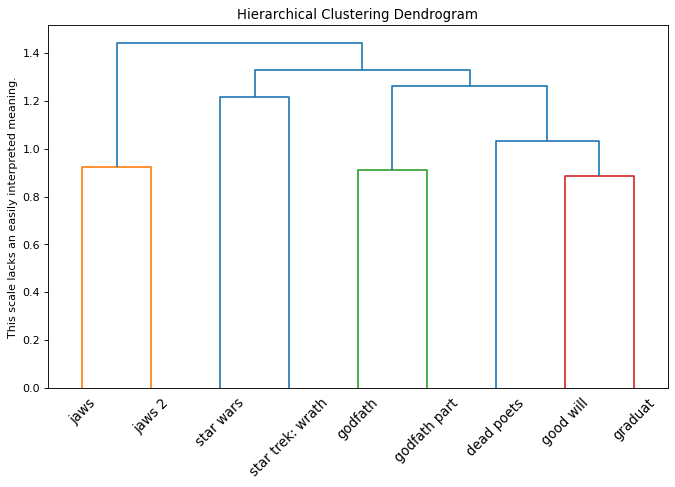

In [90]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram.
    Underwood borrowed this code from
    https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# If you just want to plot the tree, you
# don't need the loop below. But if you 
# want to label the leaves by movie name,
# you need a list of movie names. And if you
# want it to come out looking pretty, you need
# to abbreviate the movie names! Most of this
# code is figuring out how to create list of
# appropriate abbreviations.
    
labelist = []
for mname in small_moviefreqs.index:
    label = []
    words = mname.split()
    for w in words:
        if len(w) > 3 and len(w) < 7 or w == '2':
            label.append(w)
        elif len(w) > 7:
            label.append(w[0:7])
        
        if len(label) > 2:
            break
            
    labelist.append(' '.join(label))

# Now let's increase the figure size
plt.figure(figsize=(10, 6), dpi=80)
plt.title('Hierarchical Clustering Dendrogram')

# calls the function above and actually plots the image
plot_dendrogram(model, truncate_mode='level', p = 7,leaf_rotation = 45,
                         labels = labelist)
plt.ylabel("This scale lacks an easily interpreted meaning.")
plt.show()

Hierarchical clustering is amazing, right? Well, to be frank, I made it look amazing by selecting titles that happen to cluster in reasonable ways. See what happens if you add 2-3 of your own favorite movie titles to the 'selected' list up at the top of this section, and then re-run all of the cells. (They need to be titles that are actually present in the database, of course.)

After playing around with this for five minutes or so, I'll ask for two or three volunteers to share their screens. It's okay if the results are not pretty! part of the point here is that clustering is often not as pretty in practice as it seems in theory.

**PAUSE TO SHARE SCREENS**

### Dimension-reduction: principal component analysis

Clustering is great in cases where there are crisp clusters to be discovered. But in the real world, things are often not organized into groups with crisp edges.

In a case like that you may need a way to visualize *relationships* rather than divide instances into separate groups.

Ideally, we'd like to inspect the relationships between movie scripts in thousand-dimensional space. Since our eyes don't see well in a thousand dimensions, we need a way to compress those similarities and differences down to two dimensions.

One classic way to do this is called "principal component analysis." Let's use it to look at some action and romance films. We'll sample 210 from the group that have one tag *or* the other. The pipe character "|" functions as a logical or in the first line below:

In [101]:
moviesubset = movies.loc[(movies['romance'] == True) | (movies['action'] == True), : ].sample(210)
subsetfreqs = moviefreqs.loc[moviesubset.index, : ]
subsetfreqs.head()

,the,what,to,it,you,of,know,me,are,that,...,referred,deposition,document,threats,ratings,inject,fragile,worthwhile,yacht,heavens
mname,,,,,,,,,,,,,,,,,,,,,
platinum blonde,0.307820,0.115000,0.310000,0.206667,0.593333,0.183639,0.070117,0.121870,0.058431,0.282137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.083333
the getaway,0.108153,0.045000,0.110000,0.113333,0.190000,0.051753,0.016694,0.031720,0.028381,0.045075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
star wars,0.249584,0.055000,0.135000,0.150000,0.265000,0.096828,0.030050,0.025042,0.043406,0.060100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
shampoo,0.211314,0.208333,0.335000,0.283333,0.723333,0.133556,0.156928,0.170284,0.068447,0.213689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
punch-drunk love,0.123128,0.096667,0.246667,0.215000,0.556667,0.055092,0.088481,0.091820,0.063439,0.218698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


Here, too, we get better results if we normalize the rows by vector length, so they're all length 1.

In [102]:
vectorlengths = np.linalg.norm(subsetfreqs, ord = 2, axis = 1)
normed_subset = subsetfreqs.divide(vectorlengths, axis = 'rows')

**Principal component analysis**

For an intuitive visual explainer on PCA, you can consult [a blog post by Victor Powell.](https://setosa.io/ev/principal-component-analysis/) For our purposes, you can envision it as a process that chooses the best "camera angle" to view a high-dimensional space -- an angle where the points spread out as much as possible in a smaller-dimensional representation, like say a plane.

Because you're viewing the original space at an angle, the axes in the new reduced space each represent some *algebraic combination* of the original dimensions. So you can't label the x and y axes in a PCA plot in any simple way.

As usual scikit-learn makes the math easy. You just import PCA and specify that you want to reduce your data to two "components" (aka dimensions). Then you can fit the model and transform your data in a single step.

In [103]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
components = pca.fit_transform(normed_subset)
components.shape

(210, 2)

Here are our action and romance movies spread out in a plane.

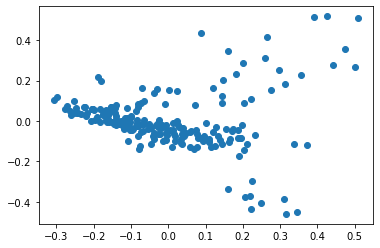

In [104]:
plt.scatter(components[ : , 0], components[ : , 1])

Of course, to understand what we're seeing, it would be helpful to see which of those points are romance movies, or action movies, or both. Let's create a list that we can use to color the points.

In [105]:
def genre2color(row):
    color = 'other'
    
    genrecount = 0
    
    if row['romance']:
        color = 'romance'
        genrecount += 1
    if row['action']:
        color = 'action'
        genrecount += 1
        
    if genrecount > 1:
        color = 'both'
    
    return color

colorseq = []

for idx, row in moviesubset.iterrows():
    thiscolor = genre2color(row)
    colorseq.append(thiscolor)

That's probably enough information, but ... it would be a little nicer if we could label some of the outliers.

Unfortunately, figuring out "which are the outliers" gets a little complicated ...

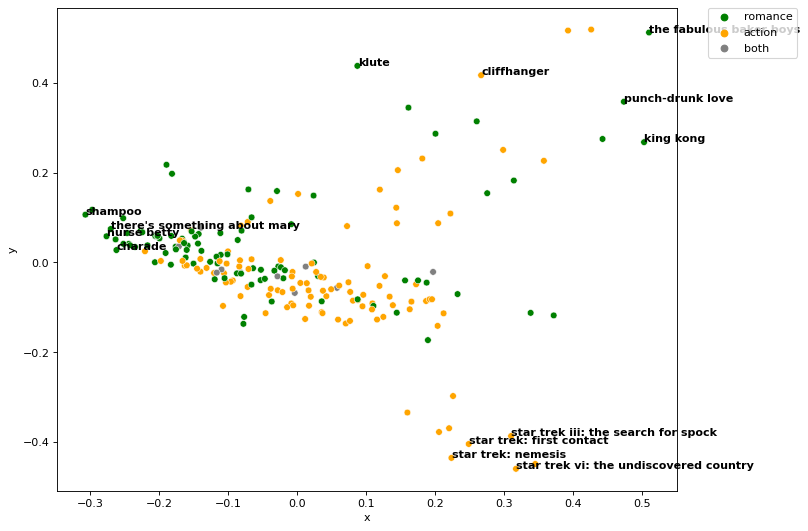

In [134]:
plotframe = pd.DataFrame({'x': components[ : , 0], 'y': components[ : , 1],
                         'color': colorseq})
colordict = {'other': 'black', 'action': 'orange',
            'both': 'gray', 'romance': 'green'}

plt.figure(figsize=(10, 8), dpi=80)
theplot = sns.scatterplot(data = plotframe, x = 'x', y = 'y', hue = 'color',
               palette = colordict)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# The code below is all about labeling outliers.
# I'm using a complex strategy to make sure the
# outliers we label are evenly distributed and not so
# close to each other that the labels overlap.

meanx = np.mean(plotframe['x'])
meany = np.mean(plotframe['y'])

outliers = []
skip = set()

for points_labeled in range(18):
    
    distances = []

    for linenum in range(plotframe.shape[0]):
        if linenum in outliers or linenum in skip:
            continue
        else:
            euclidnorm = math.sqrt((plotframe.x[linenum] - meanx) ** 2 + (plotframe.y[linenum] - meany) **2)
            distances.append((euclidnorm, linenum))

    distances.sort()

    chosen = distances[-1][1]
    tooclose = False
    
    for already_have in outliers:
        verticaldist = abs(plotframe.y[already_have] - plotframe.y[chosen])
        if verticaldist < 0.015:
            tooclose = True
            skip.add(chosen)
            
    if not tooclose:        
        outliers.append(chosen)

    meanx = np.mean([meanx, np.mean(plotframe.loc[outliers, 'x'])])
    meany = np.mean([meany, np.mean(plotframe.loc[outliers, 'y'])])


for line in outliers:
     theplot.text(plotframe.x[line]+0.0005, plotframe.y[line] + .0005, 
     moviesubset.index[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.show()

Because we've randomly sampled 210 movies from the 268 that had "action" or "romance" tags, everyone's going to get a slightly different plot. But I suspect we all will see that there's a space of the PCA plane with distinctly more romances--and also a corner with a bunch of *Star Trek* movies--and also a few weird romances that don't hang out with the others.

This is *unsupervised*; the analysis doesn't know which dots are green and which are orange. It's just looking for a viewing angle that makes things spread out as much as possible. Since action movies are pretty different from romances, that happens to be an angle of view pretty perpendicular to the axis of differentiation between those two genres.

If you want to understand the axes of PCA it *is* possible to extract an explanation. You can create a matrix ...

In [107]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=normed_subset.columns)
loadings.iloc[0:4, ]

,PC1,PC2
the,-0.167353,-0.087473
what,-0.114808,0.034895
to,-0.225843,0.017568
it,-0.191972,0.056736


... and then sort each column to figure out which of the original variables play a big role in defining the ends of the axis. E.g., here's the left-hand side of the X axis. In most of the plots I've produced, this is a pole that attracts many (though not all) of the romances:

In [110]:
loadings['PC1'].sort_values()[0:10]

you    -0.507004
to     -0.225843
it     -0.191972
the    -0.167353
that   -0.142067
oh     -0.140386
and    -0.126885
what   -0.114808
me     -0.109241
don    -0.091853
Name: PC1, dtype: float64

### Homework preview

I think I'm going to give you a choice of projects in the homework. One would be to apply PCA to movies selected from a wider range of genres, and see if genres still separate in the plot.

Another would be to *transpose* our matrix, so rows become columns and columns rows, and then apply PCA in order to plot *words* in movie-space.

A third possibility is to go back to the original character data frame and write some code that finds the nearest words to a selected word in character-space rather than movie-space. Does this bring us any closer to a model of meaning?